In [1]:
pip install pydictionaria

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.2/58.2 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.9/88.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 561.4/561.4 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.0/56.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.4/213.4 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.1/562.1 kB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5

In [2]:
! git clone https://github.com/dictionaria/kalamang.git

Cloning into 'kalamang'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (96/96), done.
remote: Total 176 (delta 95), reused 152 (delta 74), pack-reused 0 (from 0)
Receiving objects: 100% (176/176), 949.08 KiB | 10.43 MiB/s, done.
Resolving deltas: 100% (95/95), done.


In [3]:
%cd kalamang

/content/kalamang


In [4]:
from collections import ChainMap
from itertools import chain
import pathlib
import re
import sys

from pydictionaria.sfm_lib import Database as SFM
from pydictionaria import sfm2cldf

from pydictionaria.preprocess_lib import (
    marker_fallback_sense, marker_fallback_entry, merge_markers
)

from cldfbench import CLDFSpec, Dataset as BaseDataset


SEMANTIC_DOMAINS = (
    'aquatic life',
    'arrange, hold, transfer',
    'birds',
    'bodily states, colours, dimensions, quantity',
    'body',
    'canoe parts',
    'culture and communication',
    'earth',
    'food, cooking, fire',
    'relational nouns',
    'house parts',
    'human artifacts',
    'impact, cut, break',
    'insects and small animals',
    'kin',
    'location, direction, time',
    'medicines',
    'motion',
    'other animals',
    'placenames',
    'plants',
    'sounds, smells, sensations, vision',
    'state',
    'values and emotions',
    'work',
)

PENDING_SIGNIFIERS = {'tentative', 'pending'}

VAR_MARKERS = {
    'lx',
    'lx_Kar',
    'hm',
    'ph_Kar',
    'va',
    'vt',
    'lf',
    'vet',
    'mn',
    'cet',
    'se',
    'co_Dut',
    'dt',
}


class DropTracker:

    def __init__(self, crossref_markers):
        self._dropped_ids = set()
        self._crossref_markers = crossref_markers

    def dropper_func(self, fun):
        def catch_dropped(entry):
            new_entry = fun(entry)
            if new_entry is False:
                self._dropped_ids.add(
                    '{}{}'.format(entry.get('lx', ''), entry.get('hm', '')))
            return new_entry
        return catch_dropped

    def _drop_crossrefs(self, mvpair):
        m, v = mvpair
        if m in self._crossref_markers:
            new_v = ' ; '.join(
                id_.strip()
                for id_ in v.split(';')
                if id_.strip() not in self._dropped_ids)
            return m, new_v
        else:
            return m, v

    def drop_crossrefs(self, entry):
        return entry.__class__(map(self._drop_crossrefs, entry))


def drop_mly(entry):
    if 'MLY' in entry.get('ps', ''):
        return False
    else:
        return entry


def drop_variant(entry):
    if {m for m, _ in entry} <= VAR_MARKERS:
        return False
    else:
        return entry


def is_pending(sense):
    return sense.get('z6', '').lower() in PENDING_SIGNIFIERS


def drop_pending(entry):
    prefix = entry.__class__()
    senses = []
    for marker, value in entry:
        if marker == 'sn':
            senses.append(entry.__class__())
            senses[-1].append((marker, value))
        elif senses:
            senses[-1].append((marker, value))
        else:
            prefix.append((marker, value))

    if senses:
        senses_left = [s for s in senses if not is_pending(s)]
        if senses_left:
            return entry.__class__(chain(prefix, *senses_left))
        else:
            return False
    elif is_pending(prefix):
        return False
    else:
        return entry


def parse_semantic_domains(value):
    rest = value.strip().lower()
    domains = []
    while rest:
        for dom in SEMANTIC_DOMAINS:
            if rest.startswith(dom):
                domains.append(dom)
                rest = rest[len(dom):].strip()
                break
        else:
            print('unkown semantic domain:', rest, file=sys.stderr)
            domains.append(rest)
            break
    return ' ; '.join(domains)


def merged_va(marker_dict):
    va = marker_dict.get('va') or ''
    vet = marker_dict.get('vet') or ''
    if va and vet:
        return '{}: {}'.format(vet, va)
    else:
        return va


def merge_mn(entry):
    mns = []
    for marker, value in entry:
        if marker == 'mn':
            mns.append(value)
        elif mns:
            yield 'mn', ' ; '.join(mns)
            yield marker, value
            mns = []
        else:
            yield marker, value
    if mns:
        yield 'mn', ' ; '.join(mns)


def mn_to_lv(entry):
    prev = None
    for marker, value in entry:
        if marker == 'mn' and prev == 'lf':
            yield 'lv', value
        else:
            yield marker, value
        prev = marker if value else None


def filter_sp_var(entry):
    if not entry.get('vet'):
        return entry
    new_entry = entry.__class__()
    prev_va = None

    for marker, value in entry:
        if marker == 'vet' and value == 'sp. var. of':
            prev_va = None
            continue

        if prev_va:
            new_entry.append(('va', prev_va))
            prev_va = None

        if marker == 'va':
            prev_va = value
        else:
            new_entry.append((marker, value))

    return new_entry


def merged_pc(marker_dict):
    eng = marker_dict.get('pc_Eng')
    kar = marker_dict.get('pc_Kar')
    if eng and kar:
        return '{} – {}'.format(eng, kar)
    else:
        return eng


def reorganize(sfm):
    dt = DropTracker({'lv', 'mn'})

    sfm.visit(dt.dropper_func(drop_mly))
    sfm.visit(dt.dropper_func(drop_variant))
    sfm.visit(dt.dropper_func(drop_pending))

    sfm.visit(dt.drop_crossrefs)

    return sfm


def preprocess(entry):
    entry = entry.__class__(
        (m, v)
        for m, v in entry
        if m != 'pc_Mal')
    entry = entry.__class__(
        (m, re.sub(r'\s*\&lt;(\s*)', r'\1', v) if m == 'esl' else v)
        for m, v in entry)

    entry = merge_markers(
        entry, ['pc_Eng', 'pc_Kar'], 'pc_Eng', format_fn=merged_pc)
    entry = marker_fallback_sense(entry, 'de', 'ge')
    entry = marker_fallback_sense(entry, 'd_Mal', 'g_Mal')

    entry = filter_sp_var(entry)

    if entry.get('mn'):
        entry = entry.__class__(merge_mn(entry))
        entry = entry.__class__(mn_to_lv(entry))

    if entry.get('sd'):
        entry = entry.__class__(
            (m, parse_semantic_domains(v) if m == 'sd' else v)
            for m, v in entry)

    return entry

def authors_string(authors):
    def is_primary(a):
        return not isinstance(a, dict) or a.get('primary', True)

    primary = ' and '.join(
        a['name'] if isinstance(a, dict) else a
        for a in authors
        if is_primary(a))
    secondary = ' and '.join(
        a['name']
        for a in authors
        if not is_primary(a))
    if primary and secondary:
        return '{} with {}'.format(primary, secondary)
    else:
        return primary or secondary


class Dataset(BaseDataset):
    dir = pathlib.Path.cwd()  # Set current working directory
    id = "kalamang"

    def cldf_specs(self):  # A dataset must declare all CLDF sets it creates.
        return CLDFSpec(
            dir=self.cldf_dir,
            module='Dictionary',
            metadata_fname='cldf-metadata.json')

    def cmd_download(self, args):
        """
        Download files to the raw/ directory. You can use helpers methods of `self.raw_dir`, e.g.

        >>> self.raw_dir.download(url, fname)
        """
        pass

    def cmd_makecldf(self, args):
        """
        Convert the raw data to a CLDF dataset.

        >>> args.writer.objects['LanguageTable'].append(...)
        """

        # read data

        md = self.etc_dir.read_json('md.json')
        properties = md.get('properties') or {}
        language_name = md['language']['name']
        isocode = md['language']['isocode']
        language_id = md['language']['isocode']
        glottocode = md['language']['glottocode']

        marker_map = ChainMap(
            properties.get('marker_map') or {},
            sfm2cldf.DEFAULT_MARKER_MAP)
        entry_sep = properties.get('entry_sep') or sfm2cldf.DEFAULT_ENTRY_SEP
        sfm = SFM(
            self.raw_dir / 'db.sfm',
            marker_map=marker_map,
            entry_sep=entry_sep)

        examples = sfm2cldf.load_examples(self.raw_dir / 'examples.sfm')

        if (self.etc_dir / 'cdstar.json').exists():
            media_catalog = self.etc_dir.read_json('cdstar.json')
        else:
            media_catalog = {}

        # preprocessing

        sfm = reorganize(sfm)
        sfm.visit(preprocess)

        # processing

        with open(self.dir / 'cldf.log', 'w', encoding='utf-8') as log_file:
            log_name = '%s.cldf' % language_id
            cldf_log = sfm2cldf.make_log(log_name, log_file)

            entries, senses, examples, media = sfm2cldf.process_dataset(
                self.id, language_id, properties,
                sfm, examples, media_catalog=media_catalog,
                glosses_path=self.raw_dir / 'glosses.flextext',
                examples_log_path=self.dir / 'examples.log',
                glosses_log_path=self.dir / 'glosses.log',
                cldf_log=cldf_log)

            # good place for some post-processing

            # cldf schema

            sfm2cldf.make_cldf_schema(
                args.writer.cldf, properties,
                entries, senses, examples, media)

            sfm2cldf.attach_column_titles(args.writer.cldf, properties)

            print(file=log_file)

            entries = sfm2cldf.ensure_required_columns(
                args.writer.cldf, 'EntryTable', entries, cldf_log)
            senses = sfm2cldf.ensure_required_columns(
                args.writer.cldf, 'SenseTable', senses, cldf_log)
            examples = sfm2cldf.ensure_required_columns(
                args.writer.cldf, 'ExampleTable', examples, cldf_log)
            media = sfm2cldf.ensure_required_columns(
                args.writer.cldf, 'media.csv', media, cldf_log)

            entries = sfm2cldf.remove_senseless_entries(
                senses, entries, cldf_log)

        # output

        args.writer.cldf.properties['dc:creator'] = authors_string(
            md.get('authors') or ())

        language = {
            'ID': language_id,
            'Name': language_name,
            'ISO639P3code': isocode,
            'Glottocode': glottocode,
        }
        args.writer.objects['LanguageTable'] = [language]

        args.writer.objects['EntryTable'] = entries
        args.writer.objects['SenseTable'] = senses
        args.writer.objects['ExampleTable'] = examples
        args.writer.objects['media.csv'] = media

In [23]:
! pip install pandas matplotlib networkx


# Mid-review using the CLDF dataset

Entries IDs:
0    LX000001
1         a_1
2         a_3
3    LX000002
4    LX000003
Name: ID, dtype: object

Media IDs:
0    f92bc00b1ff3429b55926a6e1634e303
1    c96129f895505e8e593b1235b0411b7c
2    7900b2fb2b67974bd6fc81d9dc855f15
3    74f309637089371624d8d3b07ef07d91
4    9c2399433e585eb4adb8a04c127fe3ca
Name: ID, dtype: object

Entries Language IDs:
['kgv']

Media Language IDs:
['kgv']

Entries with Media after cleaning:
Empty DataFrame
Columns: [ID, Language_ID_x, Headword, Part_Of_Speech, Contains, Entry_IDs, Etymology, Main_Entry, Pronunciation, Source_Language, Variant_Form, Name, Description, Media_Type, Download_URL, Language_ID_y, size]
Index: []
Number of entries with media: 0
No media files associated with lexical entries.


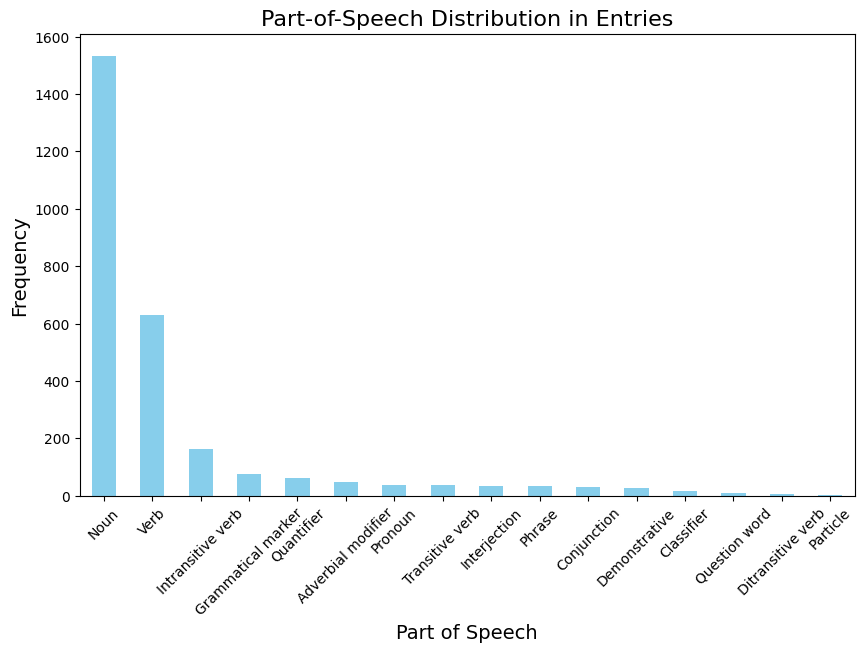

Missing senses not linked to any entry: 224
Missing examples not linked to any sense: 7


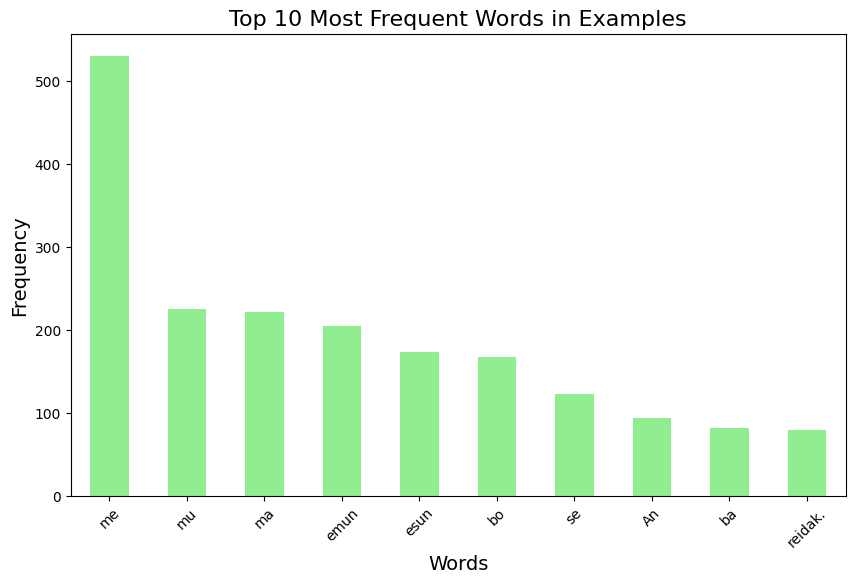

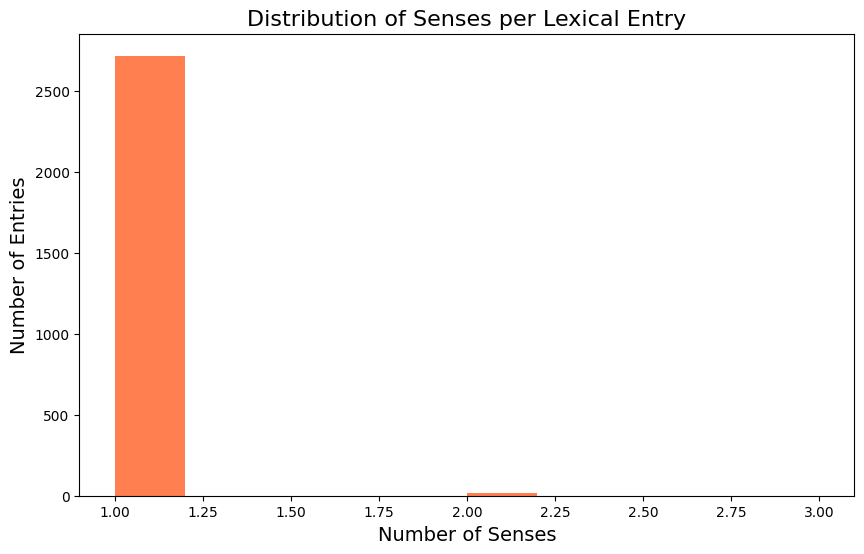

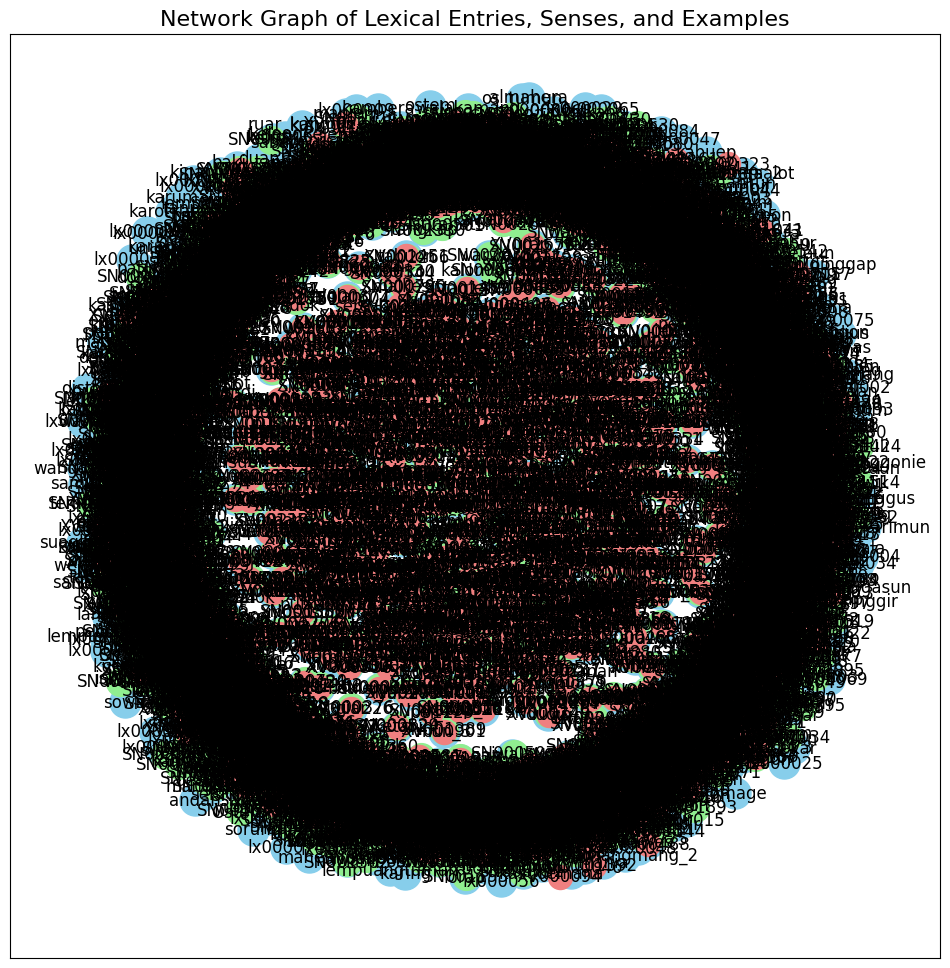

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Load the CLDF dataset CSV files
entries_df = pd.read_csv("/content/kalamang/cldf/entries.csv", sep=',')
senses_df = pd.read_csv("/content/kalamang/cldf/senses.csv", sep=',')
examples_df = pd.read_csv("/content/kalamang/cldf/examples.csv", sep=',')
media_df = pd.read_csv("/content/kalamang/cldf/media.csv", sep=',')
languages_df = pd.read_csv("/content/kalamang/cldf/languages.csv", sep=',')

# Step 1: Inspect the IDs in both entries and media to ensure proper format
print("Entries IDs:")
print(entries_df['ID'].head())

print("\nMedia IDs:")
print(media_df['ID'].head())

# Step 2: Clean the IDs by stripping whitespace and normalizing case
entries_df['ID'] = entries_df['ID'].str.strip().str.lower()
media_df['ID'] = media_df['ID'].str.strip().str.lower()

# Step 3: Check Language_IDs for consistency between the two files
print("\nEntries Language IDs:")
print(entries_df['Language_ID'].unique())

print("\nMedia Language IDs:")
print(media_df['Language_ID'].unique())

# Step 4: Merge entries and media based on cleaned 'ID'
entries_with_media = pd.merge(entries_df, media_df, left_on='ID', right_on='ID', how='inner')

# Step 5: Check the result of the merge
print("\nEntries with Media after cleaning:")
print(entries_with_media.head())
print(f"Number of entries with media: {len(entries_with_media)}")

# If there are matching entries, proceed with the analysis
if len(entries_with_media) > 0:
    # Media-to-Lexical Entry Relationship
    media_count = entries_with_media.groupby('Part_Of_Speech').size()

    # Plot the number of media files per Part of Speech
    plt.figure(figsize=(10, 6))
    media_count.plot(kind='bar', color='purple')
    plt.title("Media Associated with Lexical Entries by Part of Speech", fontsize=16)
    plt.xlabel("Part of Speech", fontsize=14)
    plt.ylabel("Number of Media Files", fontsize=14)
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No media files associated with lexical entries.")

# Continue with other analyses

# 1. Data Summary and Statistics - Part-of-Speech distribution from entries.csv
pos_distribution = entries_df['Part_Of_Speech'].value_counts()

# Plot Part-of-Speech distribution
plt.figure(figsize=(10, 6))
pos_distribution.plot(kind='bar', color='skyblue')
plt.title("Part-of-Speech Distribution in Entries", fontsize=16)
plt.xlabel("Part of Speech", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# 2. Data Integrity Checks - Check for missing senses
missing_senses = senses_df[~senses_df['Entry_ID'].isin(entries_df['ID'])]
print(f"Missing senses not linked to any entry: {len(missing_senses)}")

# Check for missing examples without corresponding senses
missing_examples = examples_df[~examples_df['Sense_IDs'].isin(senses_df['ID'])]
print(f"Missing examples not linked to any sense: {len(missing_examples)}")

# 3. Word Frequency Analysis in Examples
word_frequency = examples_df['Primary_Text'].str.split(expand=True).stack().value_counts()

# Plot the top 10 most frequent words
plt.figure(figsize=(10, 6))
word_frequency.head(10).plot(kind='bar', color='lightgreen')
plt.title("Top 10 Most Frequent Words in Examples", fontsize=16)
plt.xlabel("Words", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(rotation=45)
plt.show()

# 4. Lexicon Insights - Multiple Senses per Word
senses_per_entry = senses_df['Entry_ID'].value_counts()

# Plot the distribution of senses per entry
plt.figure(figsize=(10, 6))
senses_per_entry.plot(kind='hist', bins=10, color='coral')
plt.title("Distribution of Senses per Lexical Entry", fontsize=16)
plt.xlabel("Number of Senses", fontsize=14)
plt.ylabel("Number of Entries", fontsize=14)
plt.show()

# 5. Network Graph: Entries, Senses, and Examples
G = nx.Graph()

# Add nodes for entries
for idx, row in entries_df.iterrows():
    G.add_node(row['ID'], label=row['Headword'], type='entry')  # Ensure 'type' is set to 'entry'

# Add nodes for senses and link them to entries
for idx, row in senses_df.iterrows():
    G.add_node(row['ID'], label=row['Description'], type='sense')  # Ensure 'type' is set to 'sense'
    G.add_edge(row['Entry_ID'], row['ID'])  # Link senses to corresponding entries

# Add nodes for examples and link them to senses
for idx, row in examples_df.iterrows():
    G.add_node(row['ID'], label=row['Primary_Text'], type='example')  # Ensure 'type' is set to 'example'
    for sense_id in row['Sense_IDs'].split(';'):  # Handle multiple sense IDs if they exist
        if sense_id in G.nodes:
            G.add_edge(sense_id, row['ID'])  # Link examples to corresponding senses

# Plot the network graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)

# Separate nodes by their 'type'
entry_nodes = [n for n in G.nodes if G.nodes[n].get('type') == 'entry']
sense_nodes = [n for n in G.nodes if G.nodes[n].get('type') == 'sense']
example_nodes = [n for n in G.nodes if G.nodes[n].get('type') == 'example']

# Draw the nodes
nx.draw_networkx_nodes(G, pos, nodelist=entry_nodes, node_color='skyblue', label='Entries', node_size=500)
nx.draw_networkx_nodes(G, pos, nodelist=sense_nodes, node_color='lightgreen', label='Senses', node_size=400)
nx.draw_networkx_nodes(G, pos, nodelist=example_nodes, node_color='lightcoral', label='Examples', node_size=300)

# Draw the edges
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)

plt.title("Network Graph of Lexical Entries, Senses, and Examples", fontsize=16)
plt.show()

# Summarize the number of lexical entries, senses, examples, and media associations

In [22]:

summary = {
    "Total Lexical Entries": len(entries_df),
    "Total Senses": len(senses_df),
    "Total Examples": len(examples_df),
    "Entries with Media": len(entries_with_media),
    "Entries with Examples": examples_df['Sense_IDs'].nunique()  # Remove the len() here
}

# Print the summary of the dataset
print("Summary of Dataset:", summary)


Summary of Dataset: {'Total Lexical Entries': 2737, 'Total Senses': 2757, 'Total Examples': 1763, 'Entries with Media': 0, 'Entries with Examples': 1721}


# Distribution of Senses by Part of Speech

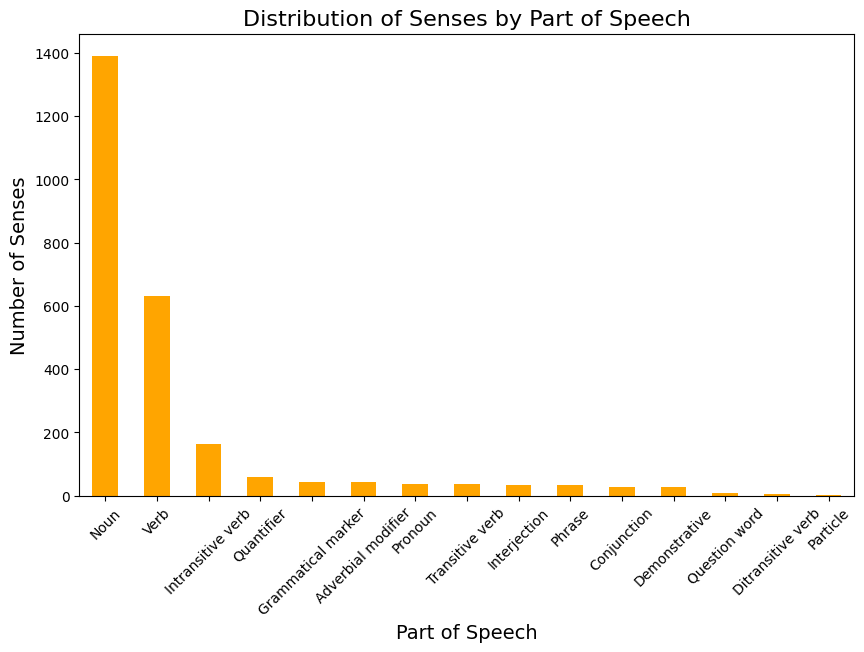

In [25]:
senses_with_pos = pd.merge(senses_df, entries_df[['ID', 'Part_Of_Speech']], left_on='Entry_ID', right_on='ID')
pos_sense_dist = senses_with_pos['Part_Of_Speech'].value_counts()

plt.figure(figsize=(10, 6))
pos_sense_dist.plot(kind='bar', color='orange')
plt.title("Distribution of Senses by Part of Speech", fontsize=16)
plt.xlabel("Part of Speech", fontsize=14)
plt.ylabel("Number of Senses", fontsize=14)
plt.xticks(rotation=45)
plt.show()


# Geospatial Visualizations:

In [27]:
import folium

# Initialize a map centered on an approximate location
m = folium.Map(location=[-3.0, 136.0], zoom_start=6)  # Use appropriate latitude and longitude

# Add a marker for each language
for idx, row in languages_df.iterrows():
    if not pd.isnull(row['Latitude']) and not pd.isnull(row['Longitude']):
        folium.Marker(
            location=[row['Latitude'], row['Longitude']],
            popup=f"Language: {row['Name']}, Glottocode: {row['Glottocode']}",
        ).add_to(m)

# Display the map
m.save('language_map.html')  # Save as an HTML file to share with others


# Semantic Domains Analysis

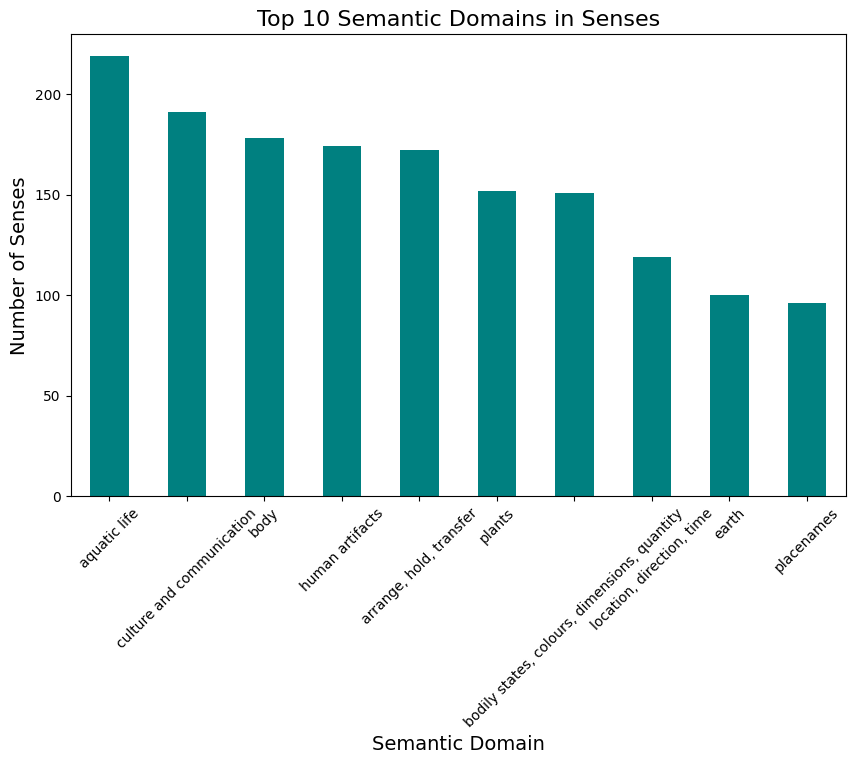

In [29]:
semantic_domain_dist = senses_df['Semantic_Domain'].value_counts().head(10)  # Top 10 semantic domains

plt.figure(figsize=(10, 6))
semantic_domain_dist.plot(kind='bar', color='teal')
plt.title("Top 10 Semantic Domains in Senses", fontsize=16)
plt.xlabel("Semantic Domain", fontsize=14)
plt.ylabel("Number of Senses", fontsize=14)
plt.xticks(rotation=45)
plt.show()


#Text Analysis of examples:

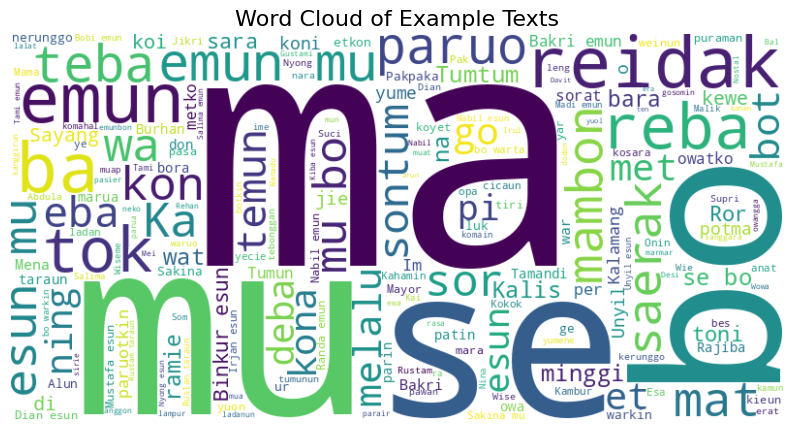

In [30]:
from wordcloud import WordCloud

text_data = ' '.join(examples_df['Primary_Text'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Example Texts", fontsize=16)
plt.show()


# Simple Part of Speech Prediction

In [31]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

# Prepare data for a simple POS classification task
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(entries_df['Headword'].fillna(''))
y = entries_df['Part_Of_Speech']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple classifier
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

# Check the accuracy
accuracy = clf.score(X_test, y_test)
print(f"Part of Speech Prediction Accuracy: {accuracy:.2%}")


Part of Speech Prediction Accuracy: 11.68%


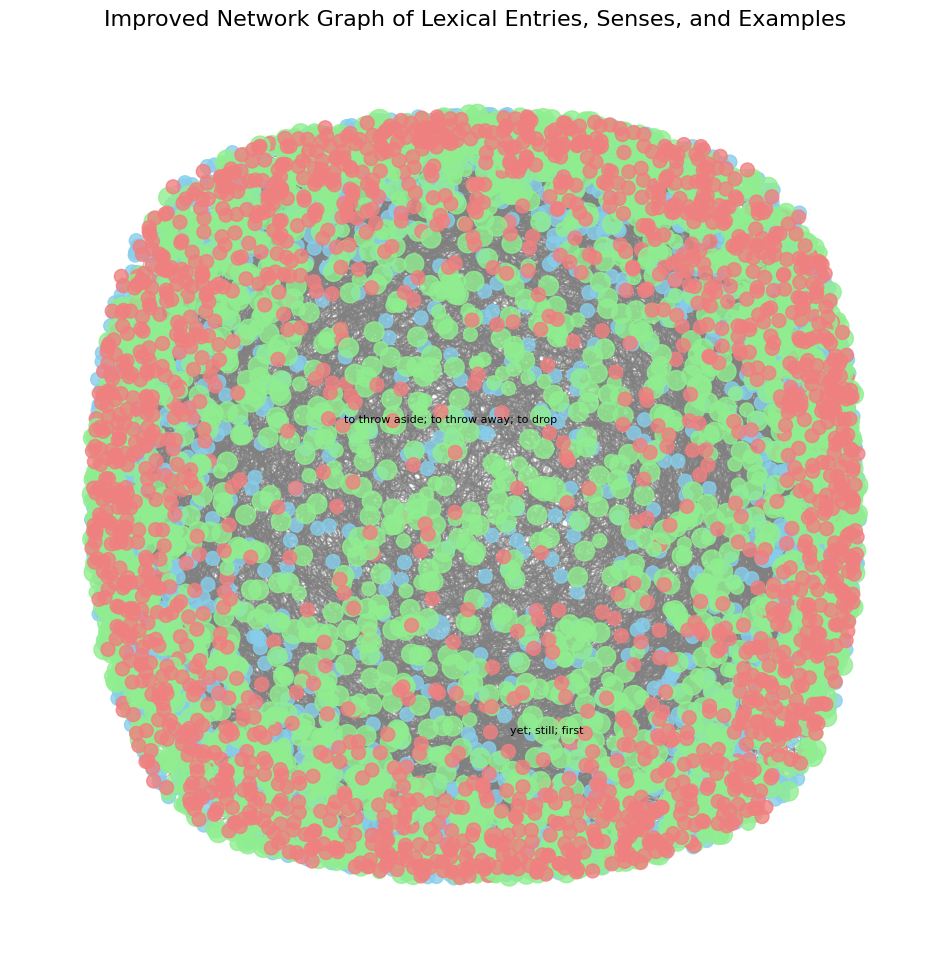

In [34]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph with clear visual distinction
G = nx.Graph()

# Add nodes for entries with the 'type' attribute
for idx, row in entries_df.iterrows():
    G.add_node(row['ID'], label=row['Headword'], type='entry')

# Add nodes for senses with the 'type' attribute, and link them to entries
for idx, row in senses_df.iterrows():
    G.add_node(row['ID'], label=row['Description'], type='sense')
    G.add_edge(row['Entry_ID'], row['ID'])  # Link senses to entries

# Add nodes for examples with the 'type' attribute, and link them to senses
for idx, row in examples_df.iterrows():
    G.add_node(row['ID'], label=row['Primary_Text'], type='example')
    for sense_id in row['Sense_IDs'].split(';'):
        if sense_id in G.nodes:
            G.add_edge(sense_id, row['ID'])  # Link examples to senses

# Define the layout for the nodes (spring layout reduces overlap)
pos = nx.spring_layout(G, k=0.15, iterations=20)

# Set node color based on type
node_color_map = []
for node in G.nodes(data=True):
    node_type = node[1].get('type')  # Safely get the 'type' to avoid KeyError
    if node_type == 'entry':
        node_color_map.append('skyblue')
    elif node_type == 'sense':
        node_color_map.append('lightgreen')
    else:
        node_color_map.append('lightcoral')

# Set node size based on degree (number of connections)
node_size_map = [G.degree(node) * 100 for node in G.nodes()]

# Draw the network graph
plt.figure(figsize=(12, 12))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_color_map, node_size=node_size_map, alpha=0.8)

# Draw edges with reduced transparency for clarity
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

# Draw only a subset of labels to avoid clutter
labels_to_show = {node: G.nodes[node]['label'] for node in G.nodes() if G.degree(node) > 3}  # Show labels only for important nodes
nx.draw_networkx_labels(G, pos, labels=labels_to_show, font_size=8)

# Turn off the axis and show the graph
plt.title("Improved Network Graph of Lexical Entries, Senses, and Examples", fontsize=16)
plt.axis('off')
plt.show()


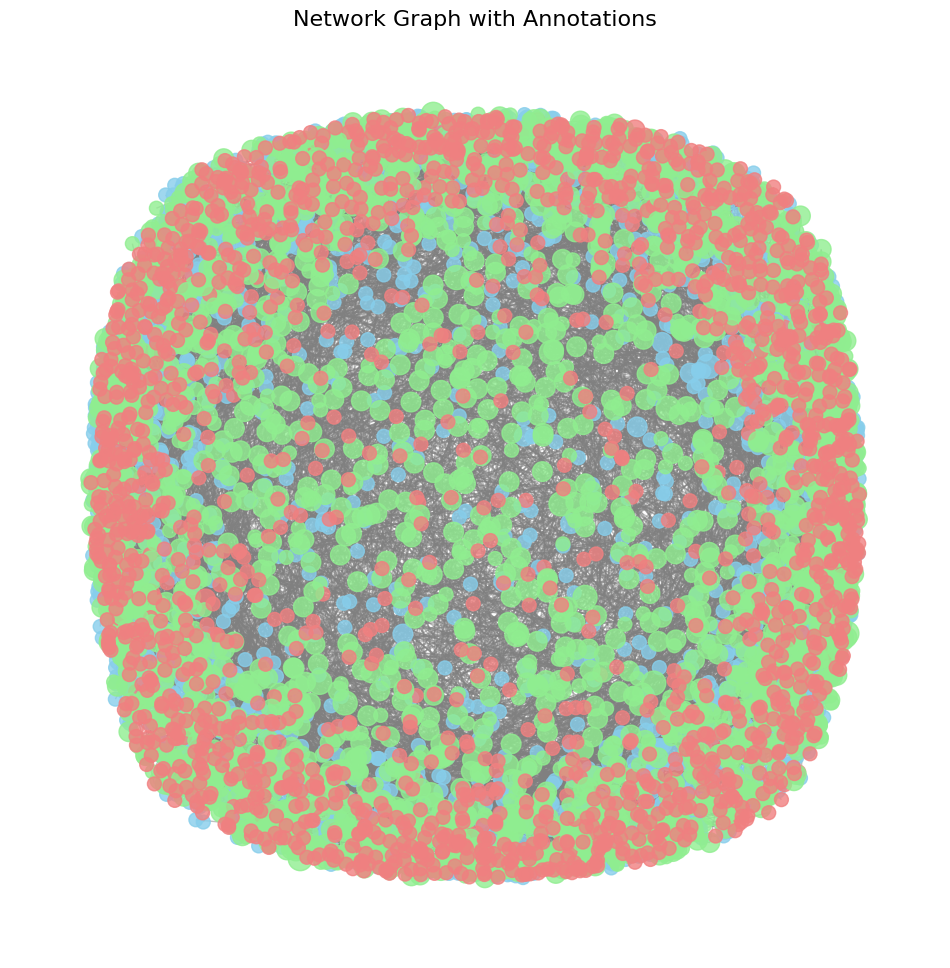

In [35]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph again with clear visual distinction
G = nx.Graph()

# Add nodes for entries, senses, and examples with 'type' attribute
for idx, row in entries_df.iterrows():
    G.add_node(row['ID'], label=row['Headword'], type='entry')

for idx, row in senses_df.iterrows():
    G.add_node(row['ID'], label=row['Description'], type='sense')
    G.add_edge(row['Entry_ID'], row['ID'])  # Link senses to entries

for idx, row in examples_df.iterrows():
    G.add_node(row['ID'], label=row['Primary_Text'], type='example')
    for sense_id in row['Sense_IDs'].split(';'):
        if sense_id in G.nodes:
            G.add_edge(sense_id, row['ID'])  # Link examples to senses

# Define the layout for the nodes
pos = nx.spring_layout(G, k=0.15, iterations=20)

# Set node color based on type
node_color_map = []
for node in G.nodes(data=True):
    node_type = node[1].get('type')  # Safely get the 'type' to avoid KeyError
    if node_type == 'entry':
        node_color_map.append('skyblue')
    elif node_type == 'sense':
        node_color_map.append('lightgreen')
    else:
        node_color_map.append('lightcoral')

# Set node size based on degree (number of connections)
node_size_map = [G.degree(node) * 100 for node in G.nodes()]

# Draw the network graph
plt.figure(figsize=(12, 12))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color=node_color_map, node_size=node_size_map, alpha=0.8)

# Draw edges with reduced transparency for clarity
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5)

# Manually place annotations with arrows pointing to the nodes
# Define a subset of nodes to annotate (high-degree or important nodes)
important_nodes = {node: G.nodes[node]['label'] for node in G.nodes() if G.degree(node) > 5}

for node, label in important_nodes.items():
    # Get the node position
    x, y = pos[node]
    # Annotate with an arrow pointing to the node
    plt.annotate(
        label,
        xy=(x, y),  # Point to the node
        xytext=(x + 0.05, y + 0.05),  # Position label slightly away from node
        arrowprops=dict(facecolor='black', shrink=0.05),  # Draw arrow
        fontsize=8
    )

# Turn off the axis and show the graph
plt.title("Network Graph with Annotations", fontsize=16)
plt.axis('off')
plt.show()


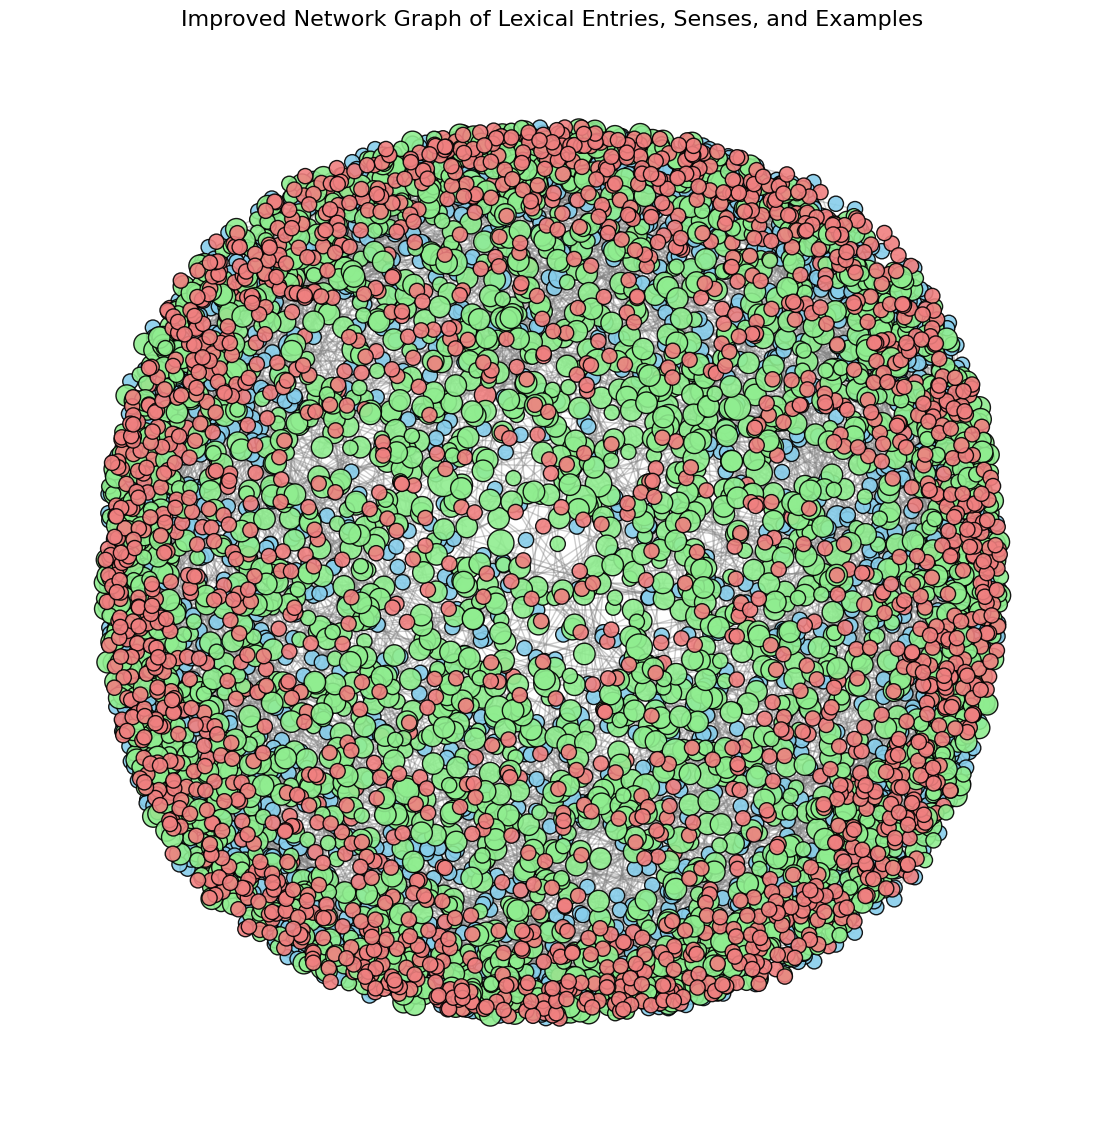

In [36]:
import networkx as nx
import matplotlib.pyplot as plt

# Create the graph with clear visual distinction
G = nx.Graph()

# Add nodes for entries, senses, and examples with 'type' attribute
for idx, row in entries_df.iterrows():
    G.add_node(row['ID'], label=row['Headword'], type='entry')

for idx, row in senses_df.iterrows():
    G.add_node(row['ID'], label=row['Description'], type='sense')
    G.add_edge(row['Entry_ID'], row['ID'])  # Link senses to entries

for idx, row in examples_df.iterrows():
    G.add_node(row['ID'], label=row['Primary_Text'], type='example')
    for sense_id in row['Sense_IDs'].split(';'):
        if sense_id in G.nodes:
            G.add_edge(sense_id, row['ID'])  # Link examples to senses

# Define the layout for the nodes
pos = nx.spring_layout(G, k=0.15, iterations=50)

# Set node color based on type
node_color_map = []
for node in G.nodes(data=True):
    node_type = node[1].get('type')  # Safely get the 'type' to avoid KeyError
    if node_type == 'entry':
        node_color_map.append('skyblue')
    elif node_type == 'sense':
        node_color_map.append('lightgreen')
    else:
        node_color_map.append('lightcoral')

# Set node size based on degree (number of connections)
node_size_map = [G.degree(node) * 120 for node in G.nodes()]

# Draw the network graph
plt.figure(figsize=(14, 14))

# Draw nodes with transparency and size scaling
nx.draw_networkx_nodes(G, pos, node_color=node_color_map, node_size=node_size_map, alpha=0.9, edgecolors='black')

# Draw edges with transparency and lighter color
nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.4)

# Manually place annotations with arrows pointing to the nodes (only for important nodes)
important_nodes = {node: G.nodes[node]['label'] for node in G.nodes() if G.degree(node) > 7}

for node, label in important_nodes.items():
    # Get the node position
    x, y = pos[node]
    # Annotate with an arrow pointing to the node
    plt.annotate(
        label,
        xy=(x, y),  # Point to the node
        xytext=(x + 0.05, y + 0.05),  # Position label slightly away from node
        arrowprops=dict(facecolor='black', shrink=0.05),  # Draw arrow
        fontsize=10, bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white')
    )

# Turn off the axis and show the graph
plt.title("Improved Network Graph of Lexical Entries, Senses, and Examples", fontsize=16)
plt.axis('off')
plt.show()


# Prepare the Dataset

In [38]:
! pip install datasets

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00


In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset

# Load the dataset
data = pd.read_csv('/content/kalamang/cldf/examples.csv', sep=',')

# Select the relevant columns
data = data[['Primary_Text', 'Translated_Text']]

# Rename the columns for clarity
data.columns = ['source', 'target']

# Split the data into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.1)

# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)


# Tokenize and Fine-Tune MarianMT

In [41]:
!pip install evaluate


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00


In [45]:
import os

# Disable Weights & Biases logging
os.environ["WANDB_DISABLED"] = "true"

# Rest of your code remains the same
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import MarianMTModel, MarianTokenizer, Seq2SeqTrainer, Seq2SeqTrainingArguments
import evaluate

# Load the pre-trained MarianMT model and tokenizer
model_name = "Helsinki-NLP/opus-mt-en-ROMANCE"  # Modify this to use the correct model if available
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

# Tokenize the data for MarianMT
def preprocess_function(examples):
    inputs = [ex for ex in examples['source']]
    targets = [ex for ex in examples['target']]
    model_inputs = tokenizer(inputs, text_target=targets, max_length=128, truncation=True, padding="max_length")
    return model_inputs

# Tokenize datasets
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_val = val_dataset.map(preprocess_function, batched=True)

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",  # Replace deprecated `evaluation_strategy`
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    logging_dir='./logs'
)

# Initialize the trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer
)

# Fine-tune the model
trainer.train()

# Save the model
model.save_pretrained("./kalamang_translation_model")
tokenizer.save_pretrained("./kalamang_translation_tokenizer")

# Function to test the trained model
def translate_kalamang(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    translated = model.generate(**inputs)
    return tokenizer.decode(translated[0], skip_special_tokens=True)

# Example: Translate a Kalamang sentence to English
kalamang_sentence = "Ma sandalbon ladanbona ditamanunggi"
english_translation = translate_kalamang(kalamang_sentence)
print(f"Kalamang: {kalamang_sentence}\nTranslated Text: {english_translation}")

# Load BLEU metric using evaluate library
bleu = evaluate.load("bleu")

# Function to calculate BLEU score
def compute_bleu(preds, labels):
    predictions = [p.split() for p in preds]
    references = [[l.split()] for l in labels]
    return bleu.compute(predictions=predictions, references=references)

# Evaluate the model with BLEU score
predicted_translations = [translate_kalamang(text) for text in val_data['source'][:10]]
true_translations = val_data['target'][:10]
bleu_score = compute_bleu(predicted_translations, true_translations)
print(f"BLEU Score: {bleu_score['bleu']:.2f}")


/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Map:   0%|          | 0/1586 [00:00<?, ? examples/s]

Map:   0%|          | 0/177 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[65000]], 'forced_eos_token_id': 0}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 512, 'num_beams': 4, 'bad_words_ids': [[65000]], 'forced_eos_token_id': 0}


Kalamang: Ma sandalbon ladanbona ditamanunggi
Translated Text: I don't father's father's father's father's father's father's father's father's father's father's father's father's father's father's father's father's father's father's father


ValueError: Predictions and/or references don't match the expected format.
Expected format:
Feature option 0: {'predictions': Value(dtype='string', id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='sequence'), length=-1, id='references')}
Feature option 1: {'predictions': Value(dtype='string', id='sequence'), 'references': Value(dtype='string', id='sequence')},
Input predictions: ["Sakina's", "mother's", 'mother', 'is', 'small.'],
Input references: [["Sakina's", 'mother', 'can', 'steer', 'a', 'motor', 'boat.']]

In [48]:
# Function to test the trained model
def translate_kalamang(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    translated = model.generate(**inputs)
    return tokenizer.decode(translated[0], skip_special_tokens=True)

# Example: Translate a Kalamang sentence to English
kalamang_sentence = "Ma sandalbon ladanbona ditamanunggi"
english_translation = translate_kalamang(kalamang_sentence)
print(f"Kalamang: {kalamang_sentence}\nTranslated Text: {english_translation}")


Kalamang: Ma sandalbon ladanbona ditamanunggi
Translated Text: I don't father's father's father's father's father's father's father's father's father's father's father's father's father's father's father's father's father's father's father


In [52]:
!pip install sacrebleu


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.0/104.0 kB 4.8 MB/s eta 0:00:00


In [53]:
import evaluate

# Function to test the trained model
def translate_kalamang(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    translated = model.generate(**inputs)
    return tokenizer.decode(translated[0], skip_special_tokens=True)

# Example: Translate a Kalamang sentence to English
kalamang_sentence = "Ma sandalbon ladanbona ditamanunggi"
english_translation = translate_kalamang(kalamang_sentence)
print(f"Kalamang: {kalamang_sentence}\nTranslated Text: {english_translation}")

# Load ChrF metric using evaluate library
chrf = evaluate.load("chrf")

# Function to calculate ChrF score
def compute_chrf(preds, refs):
    references = [[ref] for ref in refs]  # Wrap each reference sentence in a list
    return chrf.compute(predictions=preds, references=references)

# Evaluate the model with ChrF score
predicted_translations = [translate_kalamang(text) for text in val_data['source'][:10]]
true_translations = val_data['target'][:10]

# Compute the ChrF score
chrf_score = compute_chrf(predicted_translations, true_translations)
print(f"ChrF Score: {chrf_score['score']:.2f}")


Kalamang: Ma sandalbon ladanbona ditamanunggi
Translated Text: I don't father's father's father's father's father's father's father's father's father's father's father's father's father's father's father's father's father's father's father
ChrF Score: 21.93
